<a href="https://colab.research.google.com/github/linsalrob/CF_Data_Analysis/blob/main/Jupyter/age_and_pathogenicity_minion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age and Pathogenicity

It seems that older people have more pathogens.

Do they? Can we separate that from hospital effects?

## Repeat the initial observation

I showed this in the mgi_metadata_pcas.ipynb notebook, but we also showed it elsewhere

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.stats import linregress

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib

## Read the data

In [27]:
taxa='genus'
sequence_type = "minion"

sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
# genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type, categorise=True)
print(f"The metadata df has shape: {metadata.shape}")

#df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')
df = genus_otu

The subsystems df has shape: (61, 778)
The taxonomy df has shape: (1433, 60)
The metadata df has shape: (127, 166)


In [28]:
pathogens = cf_analysis_lib.BacterialPathogens()
df['pathogen'] = df.index.isin(pathogens.get_taxonomic_levels(taxa))
df

,1068841_20180306_S,1128691_20171218_S,1128691_20180116_S,1282052_20180206_S,1316935_20180417_S,1447437_20171006_S,1447437_20171212_S,1470026_20180502_S,1565754_20171128_S,1565754_20180403_S,...,788707_20180313_S,788707_20181116_S,802971_20180605_S,825012_20181120_S,825012_20181126_S,875028_20180115_S,892355_20180123_S,895293_20180502_S,983493_20180123_S,pathogen
taxonomy,,,,,,,,,,,,,,,,,,,,,
Stahlbacteria,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Chromulinivorax,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Bradymonas,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Microvenator,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Acididesulfobacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Akkermansia,0.0,0.0,0.0,0.0,0.0,6.403689,0.0,13.204109,0.0,0.0,...,0.0,35.114825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Brevifollis,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
Luteolibacter,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Calculate the proportion of bacteria per pwCF that are pathogenic

In [29]:
# separate pathogen/non pathogens and calculate the sums per patient
pathog_df = df[df['pathogen'] == True].drop(columns='pathogen')
non_pathog_df = df[df['pathogen'] == False].drop(columns='pathogen')
total_pathogen = pathog_df.sum()
total_non_pathogen = non_pathog_df.sum()
total_counts = df.drop(columns='pathogen').sum()

# calculate the proportions and make them a df
proportion_pathogen = total_pathogen / total_counts
proportion_non_pathogen = total_non_pathogen / total_counts
proportions = pd.DataFrame({
    'Proportion Pathogen': proportion_pathogen,
    'Proportion Non-Pathogen': proportion_non_pathogen
})
proportions.head()


,Proportion Pathogen,Proportion Non-Pathogen
1068841_20180306_S,0.674334,0.325666
1128691_20171218_S,0.912088,0.087912
1128691_20180116_S,0.804651,0.195349
1282052_20180206_S,0.936298,0.063702
1316935_20180417_S,0.439453,0.560547


## Plot a graph of age vs. pathogens

<Axes: xlabel='Age', ylabel='Proportion pathogens'>

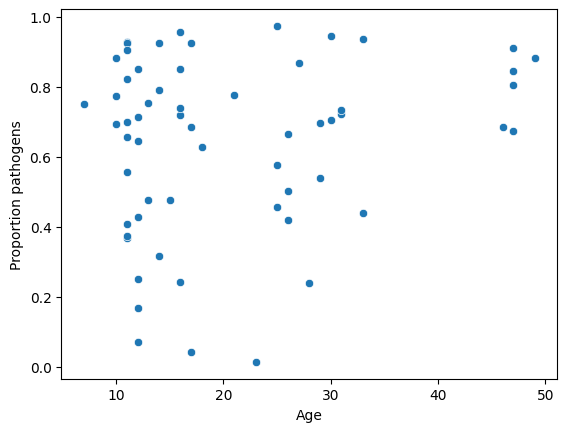

In [30]:
age_pathog = pd.DataFrame()
age_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
age_pathog = age_pathog.join(metadata[['Age']])

sns.scatterplot(data=age_pathog, x='Age', y='Proportion pathogens')

### Add some statistics

In [31]:
# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(age_pathog['Age'], age_pathog['Proportion pathogens'])

print(f"The relationship between 'Age' and 'Proportion pathogens' has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

The relationship between 'Age' and 'Proportion pathogens' has an equation of y = 0.00x + 0.56, a Pearson r of 0.18, and p=0.16


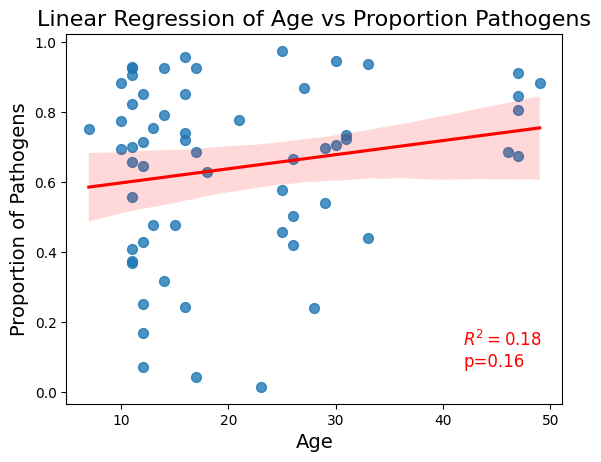

In [32]:
sns.regplot(
    x='Age', y='Proportion pathogens', data=age_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'}
)

# Annotate the plot with R-squared value
plt.text(
    0.8, 0.1, f"$R^2 = {r_value:.2f}$\np={p_value:.2f}", fontsize=12, transform=plt.gca().transAxes, color='red'
)

# Set labels and title
plt.xlabel('Age', fontsize=14)
plt.ylabel('Proportion of Pathogens', fontsize=14)
plt.title('Linear Regression of Age vs Proportion Pathogens', fontsize=16)
plt.show()


## Proportion pathogens vs. hospital

<Axes: xlabel='Paediatric vs Adult', ylabel='Proportion pathogens'>

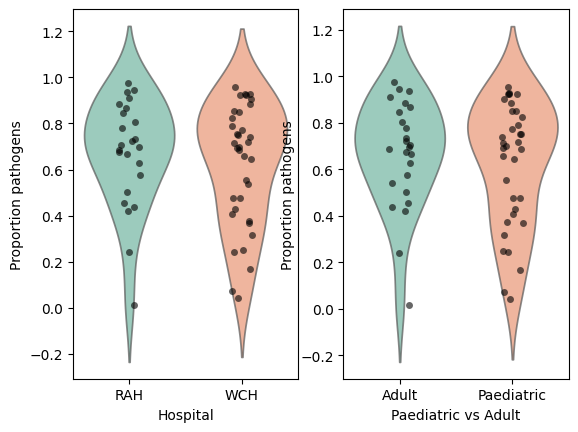

In [33]:
hosp_pathog = pd.DataFrame()
hosp_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
hosp_pathog = hosp_pathog.join(metadata[['Hospital', 'Paediatric vs Adult']])

ax = plt.subplot(121)
sns.violinplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7, ax=ax)

# Jittered points
sns.stripplot(x='Hospital', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6, ax=ax)

ax = plt.subplot(122)
sns.violinplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, inner=None, palette='Set2', alpha=0.7, ax=ax)

# Jittered points
sns.stripplot(x='Paediatric vs Adult', y='Proportion pathogens', data=hosp_pathog, color='black', jitter=True, size=5, alpha=0.6, ax=ax)

## FEV1 vs pathogenicity

Oddly, there does not seem to be a strong relationship between the proportion of pathogens and the FEV1. I would have expected there to be a negative relationship, with more pathogens at a lower FEV1/best FEV or FEV1_RATIO_SCORE.

The relationship between FEV1/best FEV1 and Proportion pathogens has an equation of y = nanx + nan, a Pearson r of nan, and p=nan


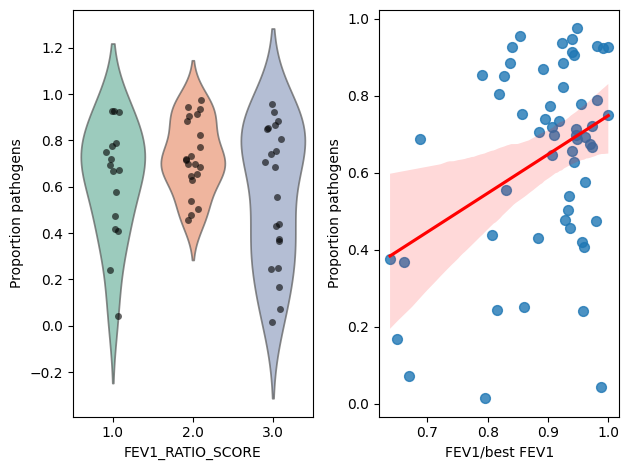

In [34]:
fev_pathog = pd.DataFrame()
fev_pathog['Proportion pathogens'] = proportions['Proportion Pathogen']
fev_pathog = fev_pathog.join(metadata[['FEV1/best FEV1', 'FEV1_RATIO_SCORE']])

ax = plt.subplot(121)

sns.violinplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, inner=None, palette='Set2', alpha=0.7, ax=ax)

# Jittered points
sns.stripplot(x='FEV1_RATIO_SCORE', y='Proportion pathogens', data=fev_pathog, color='black', jitter=True,  size=5, alpha=0.6, ax=ax)

ax = plt.subplot(122)

x='FEV1/best FEV1'
y='Proportion pathogens'
slope, intercept, r_value, p_value, std_err = linregress(fev_pathog[x], fev_pathog[y])

print(f"The relationship between {x} and {y} has an equation of y = {slope:.2f}x + {intercept:.2f}, a Pearson r of {r_value:.2f}, and p={p_value:.2f}")

sns.regplot(x=x, y=y, data=fev_pathog, scatter_kws={'s': 50}, line_kws={'color': 'red'})
#sns.scatterplot(x=x, y=y, data=fev_pathog, color='black', alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

In [35]:
pseudomonas = pathogens.get_pseudomonas_taxa(taxa)

pdf = pd.DataFrame(df.loc[pseudomonas, :].drop('pathogen')).join(metadata[['Hospital', 'Paediatric vs Adult', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE']])
pdf.head()

,Pseudomonas,Hospital,Paediatric vs Adult,FEV1/best FEV1,FEV1_RATIO_SCORE
1068841_20180306_S,485.332953,RAH,Adult,0.969388,1.0
1128691_20171218_S,0.0,RAH,Adult,0.939394,2.0
1128691_20180116_S,308.16641,RAH,Adult,0.818182,3.0
1282052_20180206_S,1597.465006,RAH,Adult,0.923077,2.0
1316935_20180417_S,280.583614,RAH,Adult,0.807692,3.0


In [36]:
df.sum(axis=0)

1068841_20180306_S    540532.438798
1128691_20171218_S    156357.388316
1128691_20180116_S    132511.556240
1282052_20180206_S    600411.150830
1316935_20180417_S    474639.557973
                          ...      
875028_20180115_S     558689.254971
892355_20180123_S     505967.092719
895293_20180502_S     578248.296107
983493_20180123_S     573541.554479
pathogen                  32.000000
Length: 61, dtype: float64

In [37]:
pdf = pd.DataFrame(df.loc[pseudomonas, :].drop('pathogen')/df.sum(axis=0).drop('pathogen')).rename(columns={0:'Proportion Pseudomonas'}).join(metadata[['Hospital', 'Paediatric vs Adult', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE']])
pdf['Proportion Pseudomonas'] = pdf['Proportion Pseudomonas'].astype(float)
pdf.head()

,Proportion Pseudomonas,Hospital,Paediatric vs Adult,FEV1/best FEV1,FEV1_RATIO_SCORE
1068841_20180306_S,0.000898,RAH,Adult,0.969388,1.0
1128691_20171218_S,0.000000,RAH,Adult,0.939394,2.0
1128691_20180116_S,0.002326,RAH,Adult,0.818182,3.0
1282052_20180206_S,0.002661,RAH,Adult,0.923077,2.0
1316935_20180417_S,0.000591,RAH,Adult,0.807692,3.0


<Axes: xlabel='Proportion Pseudomonas', ylabel='FEV1/best FEV1'>

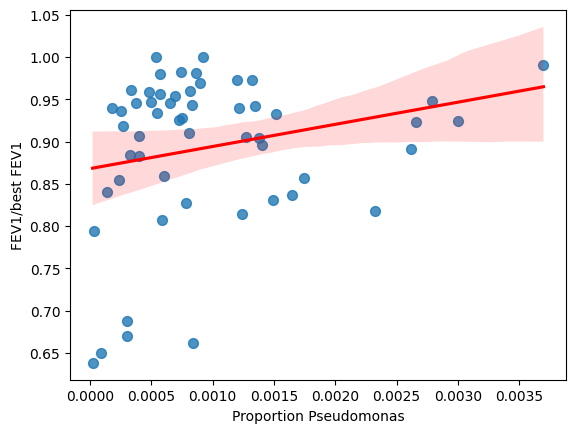

In [38]:
sns.regplot(data=pdf[pdf['Proportion Pseudomonas'] > 0], x='Proportion Pseudomonas', y='FEV1/best FEV1', scatter_kws={'s': 50}, line_kws={'color': 'red'})

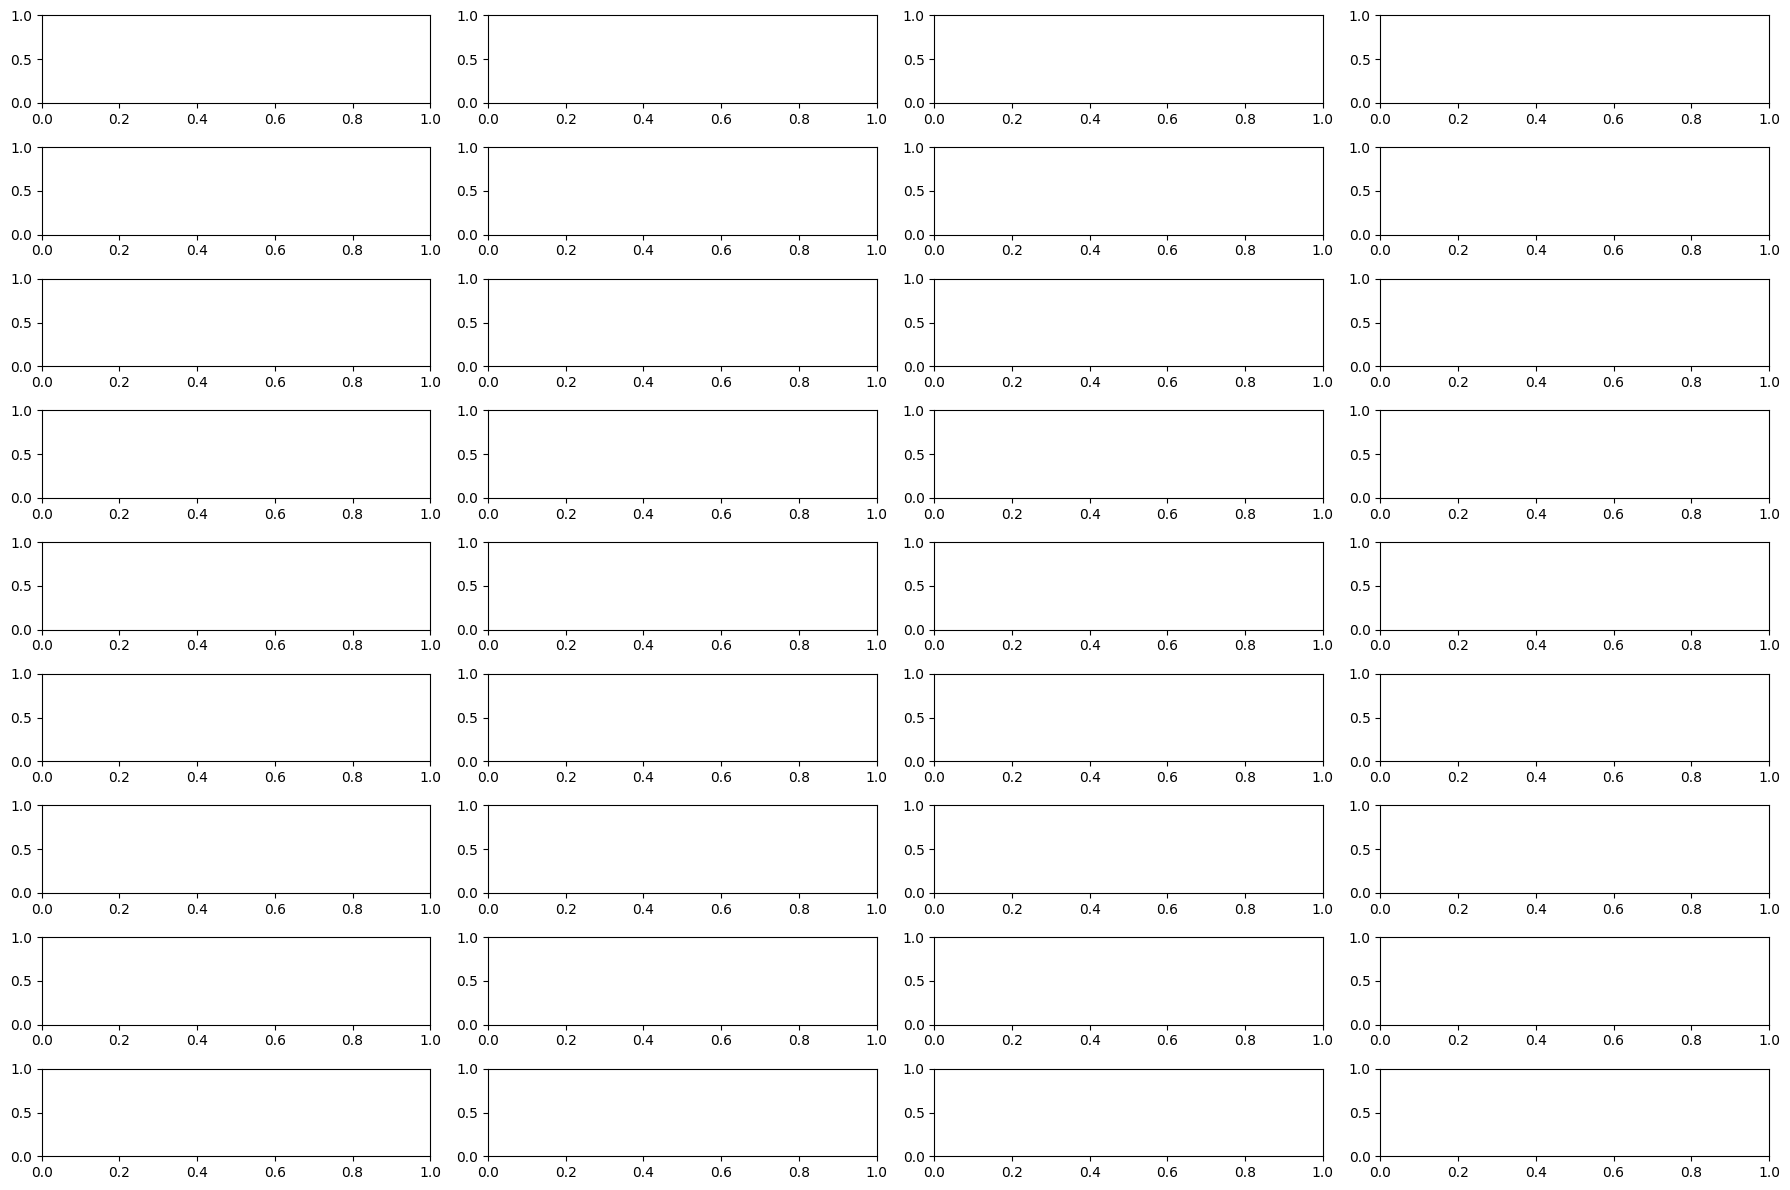

In [40]:
numrows = (len(pathogens.get_taxonomic_levels(taxa))//4)+1

fig, axes = plt.subplots(figsize=(18, 12), nrows=numrows, ncols=4, sharex=False, sharey=False)

for i, p in enumerate(pathogens.get_taxonomic_levels(taxa)):
    if p not in df.columns:
        continue
    ax = axes[i//4, i%4]
    pdf = pd.DataFrame(df.loc[p, :].drop('pathogen')/df.sum(axis=0).drop('pathogen')).rename(columns={0:f'Proportion {p}'}).join(metadata[['FEV1/best FEV1']])
    pdf[f'Proportion {p}'] = pdf[f'Proportion {p}'].astype(float)
    sns.regplot(data=pdf[pdf[f'Proportion {p}'] > 0], x=f'Proportion {p}', y='FEV1/best FEV1', scatter_kws={'s': 50}, line_kws={'color': 'red'}, ax=ax)

plt.tight_layout()
plt.show()